In [568]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings 
warnings.filterwarnings('ignore')

In [569]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [570]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


In [571]:
def display_normalized_values_for(series, dropna=False):
    print(data[series.name].value_counts(dropna=dropna, normalize=True).head(10))
    
def values_inside_iqr_for(series):
    median = series.median()
    upper_quantile = series.quantile(0.75)
    lower_quantile = series.quantile(0.25)
    iqr = upper_quantile - lower_quantile
    print('IQR ' + series.name + ' = ' + str(iqr))
    lower_bound = lower_quantile - (1.5 * iqr)
    upper_bound = upper_quantile + (1.5 * iqr)
    print('Нижняя граница выброса ' + series.name + ' = ' + str(lower_bound))
    print('Верхняя граница выброса ' + series.name + ' = ' + str(upper_bound))
    return series.between(lower_bound, upper_bound)

#### Заполнение пропусков education

In [572]:
import random

# рассмотрим как распределены уровни образования в датасете
display_normalized_values_for(data.education, dropna=False)

# для заполнения пропусков сгенерируем случайное число от 0 до 1000
# если попадает в 0.2% верхних значений -  ACD
# если в 1.7% - PGR и т. д.
educations = {'ACD': range(998, 1001),
              'PGR': range(983, 998),
              'UGR': range(846, 983),
              'GRD': range(529, 846),
              'SCH': range(0, 529)}

def fill_education_nans(element):
    if pd.isna(element):
        randomized = random.randint(0, 1000)
        for education in educations:
            if randomized in educations[education]:
                return education
    else:
        return element


if len(data[data.education.isna()]) > 0:
    data.education = data.education.apply(fill_education_nans)
    test_data.education = test_data.education.apply(fill_education_nans)

# убедимся в отсутсвии пропусков и рассмотрим новое распределение
display_normalized_values_for(data.education, dropna=False)

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
NaN    0.004160
ACD    0.002629
Name: education, dtype: float64
SCH    0.528679
GRD    0.318040
UGR    0.133552
PGR    0.017073
ACD    0.002656
Name: education, dtype: float64


#### Преобразование app_date

In [573]:
from datetime import datetime
if type(data.app_date[0]) is str:
    data.app_date = data.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
    test_data.app_date = test_data.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
    # сложно представить как нам может помочь дата подачи заявки,
    # однако можно сгенерировать числовой параметр 'month'. 
    # Тогда можно будет сравнить количество дефолтов по месяцам
    data.app_date = data.app_date.apply(lambda x: int(x.strftime("%m")))
    test_data.app_date = test_data.app_date.apply(lambda x: int(x.strftime("%m")))

#### Рассмотрим новые признаки

In [574]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'app_date']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
new_cols = ['sna', 'first_time', 'score_bki', 'region_rating']
columns = bin_cols + cat_cols + num_cols + new_cols

#### Обработка бинарных переменных

In [575]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    test_data[column] = label_encoder.fit_transform(test_data[column])
       
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,3,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,2,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,1,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,4,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


#### Обработка категориальных переменных

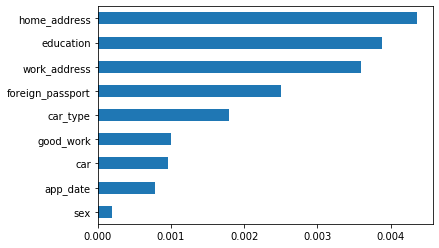

In [576]:
label_encoder.fit(data["education"])
data["education"] = label_encoder.transform(data["education"])

label_encoder.fit(test_data["education"])
test_data["education"] = label_encoder.transform(test_data["education"])

imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### Поиск выбросов

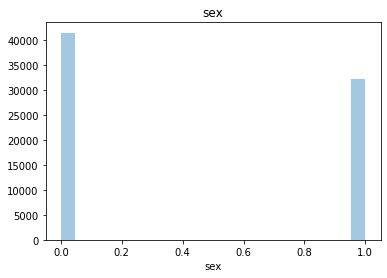

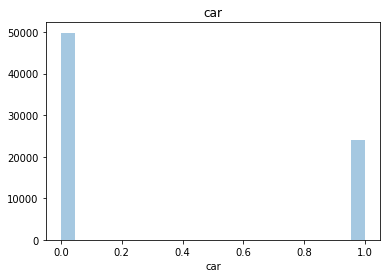

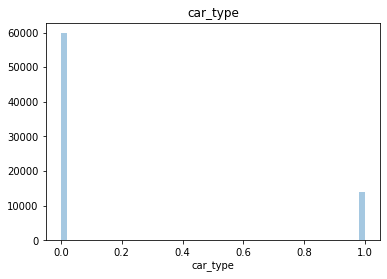

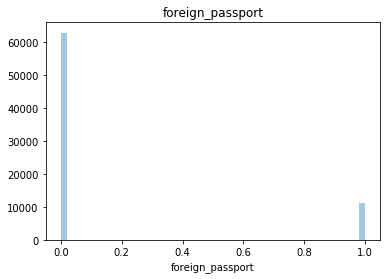

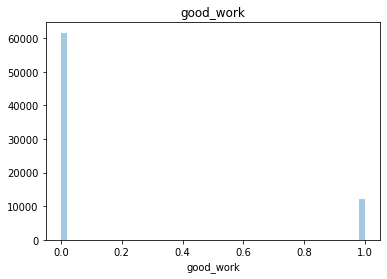

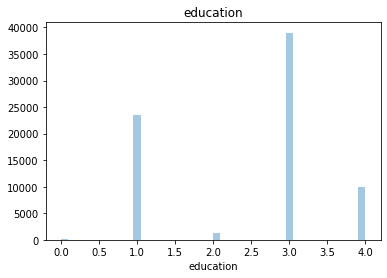

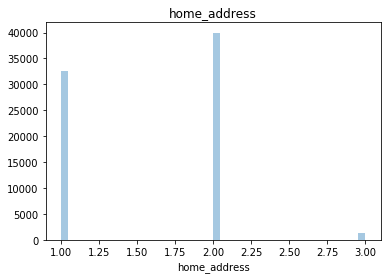

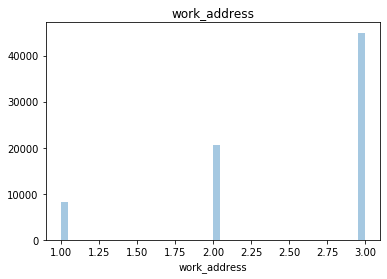

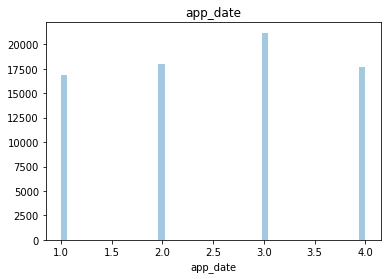

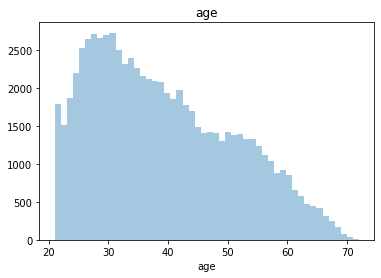

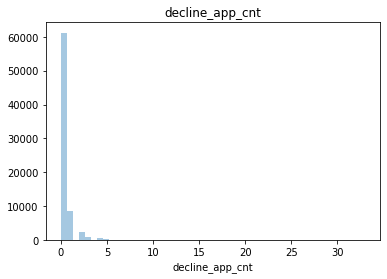

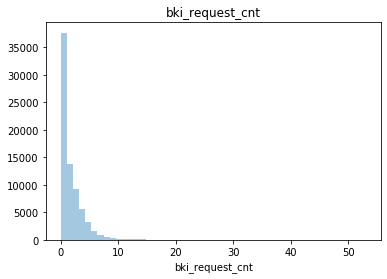

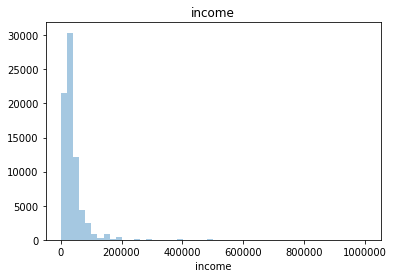

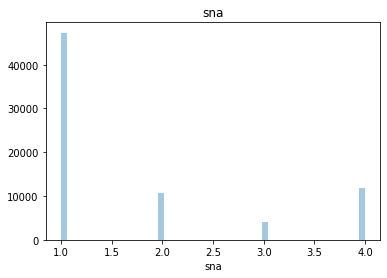

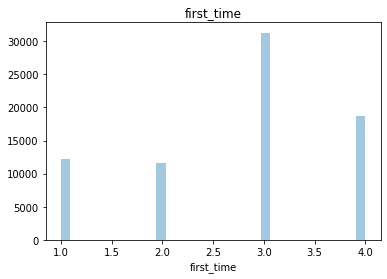

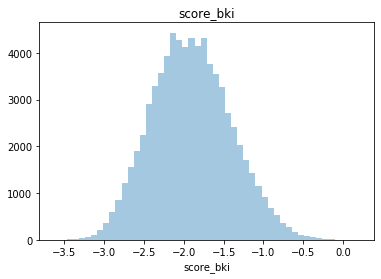

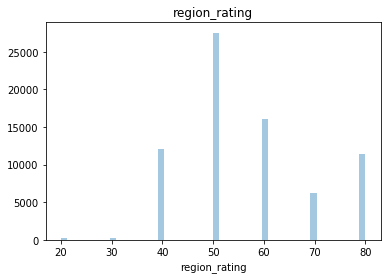

In [577]:
for i in columns:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

#### Вывод: Видим что в столбцах 'decline_app_cnt', 'bki_request_cnt' и 'income' присутсвуют выбросы - избавимся от них

In [578]:
# Так же видим, что использовать межквартильные расстояния для поиска выбросов в decline_app_cnt
# невозможно, тк IQR и обе границы равны 0, в таком случае удалим все значения выше 5

for column in ['bki_request_cnt', 'income']:
    data = data.loc[values_inside_iqr_for(data[column])]

data = data.loc[data.decline_app_cnt <= 5]

IQR bki_request_cnt = 3.0
Нижняя граница выброса bki_request_cnt = -4.5
Верхняя граница выброса bki_request_cnt = 7.5
IQR income = 25000.0
Нижняя граница выброса income = -17500.0
Верхняя граница выброса income = 82500.0


#### Распределение

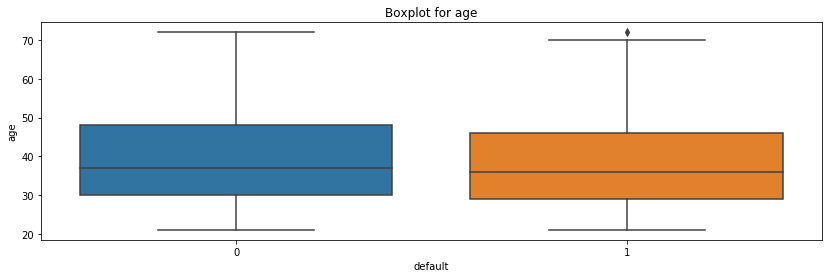

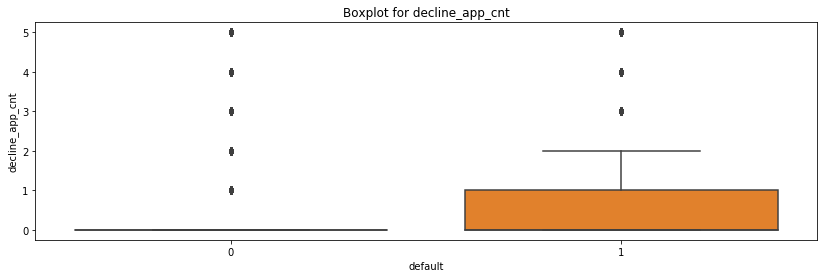

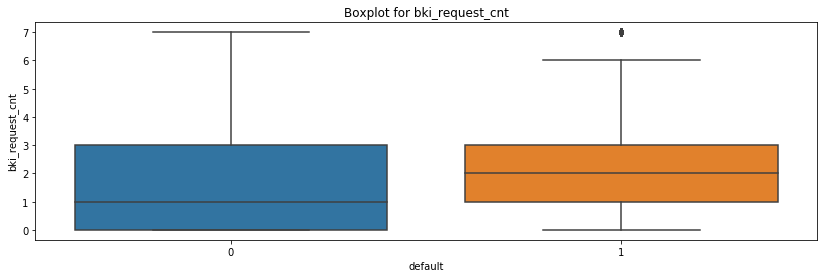

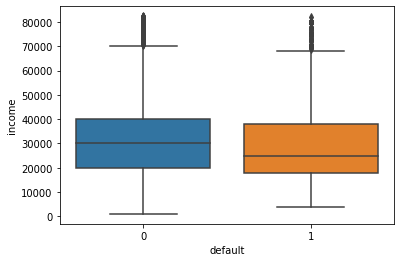

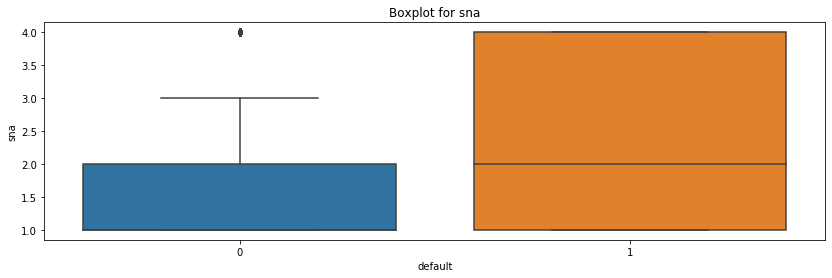

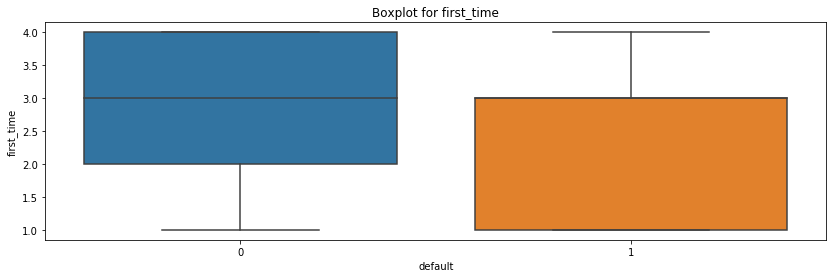

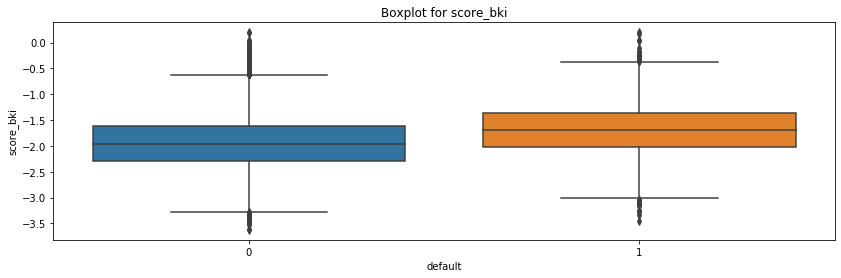

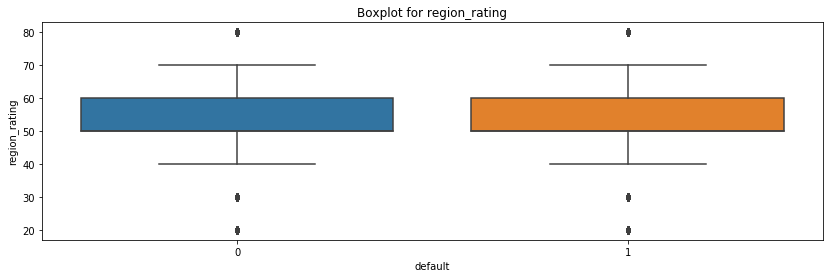

In [579]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column,
                data=data.loc[data.loc[:, column].isin(data.loc[:, column])],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in num_cols + new_cols:
    if col == 'income':
        sns.boxplot(x ='default', y = col, data = data)
    else:
        get_boxplot(col)

#### Вывод: в целом можно заметить что чем дольше заемщик знаком с банком, тем менее вероятно он будет должником так же примечательно практически полное совпадение графиков па параметру score_bki

#### Оценка корреляций

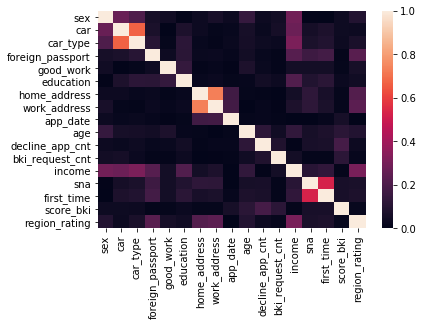

In [580]:
sns.heatmap(data[columns].corr().abs(), vmin=0, vmax=1)

In [581]:
# Видим что параметры car/car_type, home_address/work_address весьма сильно коррелируют между собой,
# да и их взаимосвязь вполне логична. Поэтому один из каждой пары можно удалить.
# Так же есть некоторая корреляция между sna и first_time, однако они, на мой взгляд не коррелируют
# с точки зрения здравого смысла, поэтому их оставим.

data.drop(['car_type', 'work_address'], axis=1, inplace=True)
test_data.drop(['car_type', 'work_address'], axis=1, inplace=True)

bin_cols = ['sex', 'car', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'app_date']

#### Непрерывность переменыых

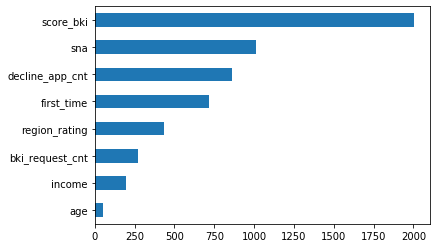

In [582]:
imp_num = Series(f_classif(data[num_cols + new_cols], data['default'])[0], index = num_cols + new_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### OneHot Encoding

In [583]:
encoder = OneHotEncoder(sparse = False)
X_cat = encoder.fit_transform(data[cat_cols].values)

X_num = StandardScaler().fit_transform(data[num_cols].values)
X_new = StandardScaler().fit_transform(data[new_cols].values)

X = np.hstack([X_num, data[bin_cols].values, X_cat, X_new])
Y = data['default'].values

encoder = OneHotEncoder(sparse = False)
X_cat_test = encoder.fit_transform(test_data[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test_data[num_cols].values)
X_new_test = StandardScaler().fit_transform(test_data[new_cols].values)
X_test_data = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test, X_new_test])

#### Обучение модели

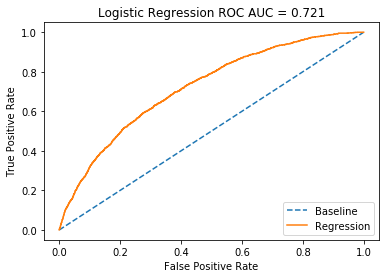

In [584]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

model = LogisticRegression()
model.fit(X_train, y_train)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Гиперпараметры

In [585]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X, Y)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, Y)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [586]:
predicted = best_model.predict(X_test_data)
submit = pd.DataFrame({'client_id': test_data.client_id, 'default': predicted})
submit.to_csv('submission.csv', index=False)